In [18]:
import torch
# torch.set_default_dtype(torch.float64)
import pickle
import matplotlib.pyplot as plt
import numpy as np
from convex_network import * 

In [49]:
with open('evp_data/2026-02-03_ElastoViscoplastic_PC1D_process0_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [50]:
E_bar = 1/np.mean(1/data['youngs_modulus'], axis=1, keepdims=True)

In [51]:
s_pred = np.zeros(data['stress'].shape)

In [52]:
xi = np.zeros((1000, 5001, 1))
dt = 1/ 5000
for i in range(data['stress'].shape[1]-1):
    increment = np.mean(E_bar**data['rate_exponent']*data['rate_constant']*np.abs(data['strain'][:,i] - xi[:,i])**data['rate_exponent']*data['yield_stress']**(-data['rate_exponent']), axis=1, keepdims=True)
    xi[:,i+1] = xi[:,i] + dt*np.sign(data['strain'][:,i] - xi[:,i])*increment
    s_pred[:,i+1] = E_bar*(data['strain'][:,i+1] - xi[:,i+1])

KeyboardInterrupt: 

In [53]:
error = np.mean((s_pred - data['stress'])**2)


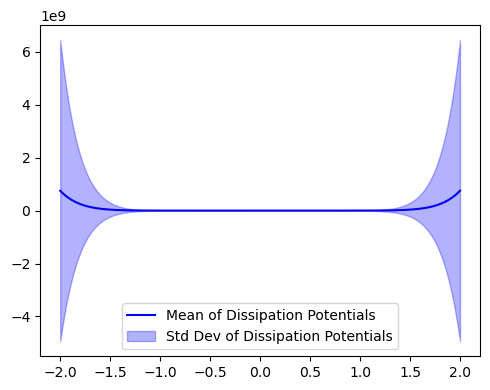

In [54]:
d = np.linspace(-2, 2, 200).reshape(-1, 1, 1)
n = data['rate_exponent']
c = data['rate_constant']
Y = data['yield_stress']
D = np.mean(c*Y**(-n)*np.abs(d)**(n+1)/(n+1), axis=2).T
D_mean = np.mean(D, axis=0)
D_std = np.std(D, axis=0)
plt.figure(figsize=(5,4))
plt.plot(d.reshape(-1), D_mean, label='Mean of Dissipation Potentials', color='blue')
plt.fill_between(d.reshape(-1), D_mean - D_std, D_mean + D_std, color='blue', alpha=0.3, label='Std Dev of Dissipation Potentials')
plt.legend()
plt.tight_layout()
plt.savefig('overleaf/Scratch/figs/viscoplastic_dissipation_potential2.pdf')
plt.show()



In [19]:
import util as util
import m_evp as m_evp
import importlib
util = importlib.reload(util)
m_evp = importlib.reload(m_evp)
loss_function = util.LossFunction()


In [20]:
with open('evp_data/2026-02-03_ElastoViscoplastic_PC1D_process0_data.pkl', 'rb') as f:
    data = pickle.load(f)
step = 10
dataset = util.ViscoplasticDataset('evp_data/2024-12-20_Viscoplastic_PC1D_process1_data.pkl', step, final_step=5000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)

for x,y in dataloader:
    e, E, Y, n, edot_0, = x
    
    
    y_pred,_ = evp_model(e, E, Y, n, edot_0)
    
    break

NameError: name 'evp_model' is not defined

In [38]:
step = 10
dataset = util.ViscoplasticDataset('evp_data/2024-12-20_Viscoplastic_PC1D_process1_data.pkl', step, final_step=5000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)
evp_model = m_evp.ViscoplasticMaterialModel([1, 1],
    dt=0.0002*step)

1 Number of internal variables in the viscoplastic material model.


In [39]:
for x,y in dataloader:
    e, E, Y, n, edot_0, = x
    
    
    y_pred,_ = evp_model(e, E, Y, n, edot_0)
    
    break

100%|██████████| 500/500 [00:03<00:00, 125.39it/s]


In [40]:
y_pred.dtype, y.dtype

(torch.float64, torch.float64)

In [29]:

loss = loss_function.L2RelativeError(y_pred, y, reduction=None)
torch.isnan(loss).sum(), len(loss)

(tensor(86), 1000)

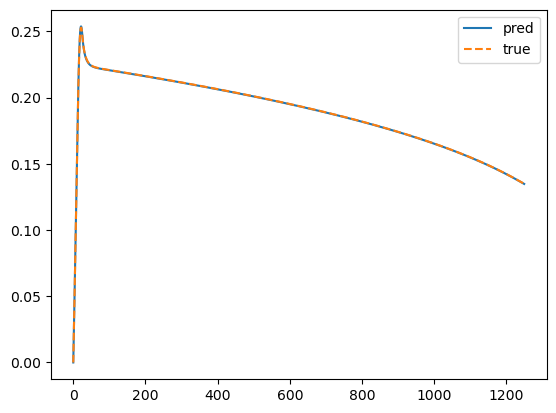

In [20]:
i=1
plt.plot(y_pred[i].detach().numpy(), label='pred')
plt.plot(y[i].detach().numpy(), '--', label='true')
plt.legend()


In [636]:
x = torch.randn(1000, 1)
n = torch.rand(1000, 1)*10 + 1
p = lambda n: n + 0.5*torch.sin(n)
out = (torch.abs(x)**p(n))

In [35]:
class PowerLayer(torch.nn.Module):
    def __init__(self):
        super(PowerLayer, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(1, 10),
            torch.nn.Softplus(),
            torch.nn.Linear(10, 10),
            torch.nn.Softplus(),
            torch.nn.Linear(10, 1)
        )
        
    def forward(self, x, n):
        return torch.abs(x)**self.model(n)

In [36]:
model = PowerLayer()

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.5e-3)


In [38]:
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    out_pred = model(x, n)
    loss = torch.nn.functional.mse_loss(out_pred, out)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

TypeError: abs(): argument 'input' (position 1) must be Tensor, not list

In [672]:
x_test = torch.linspace(-2, 2, 1000).reshape(-1, 1)
n_test = torch.tensor([[2.0]]).repeat(1000, 1)
out_test = torch.abs(x_test)**p(n_test)

In [673]:
x_test.shape, out_test.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

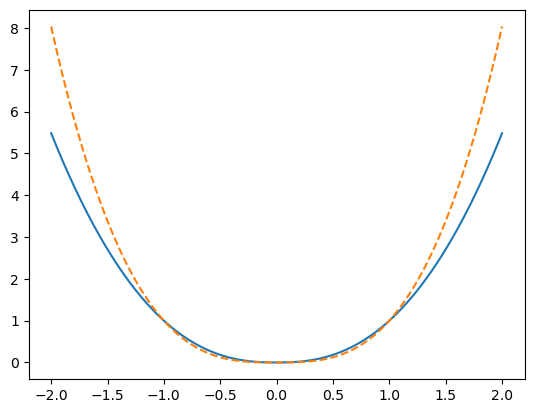

In [674]:
plt.plot(x_test.detach().numpy()[:,0], out_test.detach().numpy()[:,0], label='true')
out_pred_test = model(x_test, n_test)
plt.plot(x_test.detach().numpy()[:,0], out_pred_test.detach().numpy()[:,0], '--', label='pred')

In [ ]:
x = torch.randn(2, 100, 2, requires_grad=True)
y = lambda x: torch.einsum('ijk,ijk->ij', x, x).sum()
# g = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
# g2 = torch.autograd.grad(g, f, create_graph=True)[0]
g2 = torch.autograd.functional.hessian(y , x)


In [47]:

import torch, random, os, numpy as np

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Optional: use deterministic algorithms globally
    # Note: this may raise a RuntimeError if no deterministic algorithm is available for an operation
    # torch.use_deterministic_algorithms(True) 

seed_value = 42 # You can choose any integer
set_seed(seed_value)
# torch.set_default_dtype(torch.float64)
import pickle
import matplotlib.pyplot as plt
import numpy as np
from convex_network import * 

import util as util
import importlib 
import m_evp_adjoint
m_evp_adjoint = importlib.reload(m_evp_adjoint)
step = 5
dt = 0.0002*step
tol = 1e-5/dt
print(tol)
mm = m_evp_adjoint.ViscoplasticMaterialModel(ey_dim=1,
        niv=1,
        eout_dim=1,
        ez_dim=10,
        eu_dim=10,
        dt=dt,
        out_dim=1,
        modes=3,
        z_dim=10,
        u_dim=10,
        tol=tol,
        iter_limit=10000,
        lr=dt,
        # method='newton'
)
dataset = util.ViscoplasticDataset('data/2026-02-17_ElastoViscoplastic_PC1D_process0_data.pkl', step, final_step=2000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)
optimizer = torch.optim.Adam(mm.parameters(), lr=0.01)

0.01
1 Number of internal variables in the viscoplastic material model.


In [48]:
# dataset = util.ViscoplasticDataset('data/2026-02-17_ElastoViscoplastic_PC1D_process0_data.pkl', step, final_step=5000)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=200, shuffle=False)

In [49]:
optimizer.lr = 0.001
mm.tol = mm.tol/10

In [50]:
for epoch in range(100):
    for x,y in dataloader:
        # print('epoch:', epoch)

        e, E, Y, n, edot_0, = x
        # y = torch.zeros_like(y)
        # xi_pred = torch.zeros_like(y)
        # E_p, _ = mm.microstructure_encoder(E, Y, n, edot_0)
        # for i in range(e.shape[1]-1):
        #     xi_pred[:,i+1] = xi_pred[:,i] + mm.dt*(e[:,i+1] - xi_pred[:,i])
        #     y[:,i] = E_p*(e[:,i] - xi_pred[:,i])
        # y[:, -1] = E_p*(e[:, -1] - xi_pred[:, -1])
        y_pred, xi = mm(e, E, Y, n, edot_0)
        # break
    # loss = F.mse_loss(y_pred, y)``
        loss = mm.adjoint_loss(y, xi, e, E, Y, n, edot_0)
        # break
    # break
        loss.backward()
    # k = 0
    # for param in mm.parameters():
    #     k+=1
    #     if k == 2:
    #         # print(torch.abs(param**2 - E_p).mean())
    #     print(param, param.grad)
        optimizer.step()
        optimizer.zero_grad()
    #     break
    # break
    # if epoch % 10 == 0:
        print('loss:', loss.item())
    


loss: 0.1199965700507164
loss: 0.10510554909706116
loss: 0.10829351842403412
loss: 0.09707571566104889
loss: 0.09422917664051056
loss: 0.09047554433345795
loss: 0.08567007631063461
loss: 0.08090312033891678
loss: 0.07587786018848419
loss: 0.07123008370399475
loss: 0.06714950501918793
loss: 0.06376869231462479
loss: 0.060241300612688065
loss: 0.05681329965591431
loss: 0.054099634289741516
loss: 0.051722802221775055
loss: 0.04970486834645271
loss: 0.04828474298119545
loss: 0.047478191554546356
loss: 0.04708358272910118
loss: 0.04708446189761162
loss: 0.04738950729370117
loss: 0.0476650670170784
loss: 0.04766460880637169
loss: 0.04728960990905762
loss: 0.04674829542636871
loss: 0.04653597250580788
loss: 0.04642412066459656
loss: 0.04675453156232834
loss: nan
loss: nan
loss: nan
Energy nan
tensor([inf], grad_fn=<IndexBackward0>)


AssertionError: NaN detected in gradient during solver iterations.

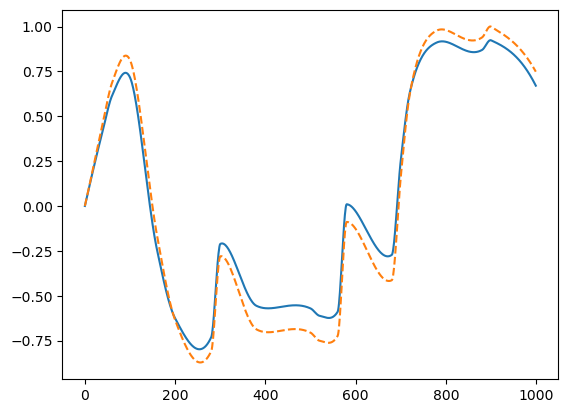

In [1323]:
i = 1
plt.plot(y_pred.detach().numpy()[i], label='pred')
plt.plot(y.detach().numpy()[i], '--', label='true')

In [1260]:
mm.dissipation_potential.parameter.grad

tensor([ 3.6097e-06,  4.5386e-06,  7.2983e-06,  3.9862e-06,  3.2521e-07,
         4.9887e-06,  2.6264e-04,  3.4584e-05,  1.8885e-05,  1.1948e-06,
        -3.9582e-07,  3.7198e-05,  4.4886e-07,  1.3395e-05,  1.5533e-04,
         1.2235e-04,  4.8212e-06,  5.2337e-05,  2.2039e-05,  1.3919e-07,
         4.2572e-04,  7.9735e-06,  6.2571e-06,  2.0399e-06,  9.4733e-05,
         3.4118e-06,  5.4043e-05,  4.2073e-07,  3.1409e-06,  5.3189e-04,
         1.7249e-03,  6.1052e-05,  1.0095e-05,  1.2412e-05, -1.1159e-06,
         1.3963e-06,  5.8343e-04,  5.5469e-06,  3.2229e-04,  2.0082e-07,
         7.9196e-06,  3.3841e-06,  1.8239e-05,  1.2664e-06,  1.8300e-07,
         2.7199e-06,  1.5948e-05,  8.2860e-05,  3.4433e-05,  2.1004e-05,
         7.7852e-05,  1.7831e-04,  9.1316e-05,  2.5714e-06,  7.5931e-05,
         9.7027e-06,  8.8363e-06,  4.0860e-05,  5.1514e-05,  3.2268e-04,
         3.2014e-06,  1.7837e-05,  2.3374e-06,  1.1102e-05,  1.0219e-06,
         1.7422e-05,  4.7393e-08,  9.1231e-06,  8.3

In [1242]:
xi.shape, 


(torch.Size([1000, 101, 1]),)

In [1255]:
torch.argmax(loss.abs().amax(dim=1)), torch.argmin(loss.amin(dim=1)), torch.mean(loss[:225])

(tensor(496), tensor(721), tensor(0.0295, grad_fn=<MeanBackward0>))

In [1151]:
plt.plot(self.C[667].detach().numpy(), label='pred')

NameError: name 'self' is not defined

In [1152]:
loss.mean()

tensor(-5.5840e+30, grad_fn=<MeanBackward0>)

In [1153]:
a = loss.mean(dim=1).flatten()

In [1154]:
a[b]

tensor([ 5.0065e-07,  1.1009e-06,  1.1778e-05,  2.3652e-04,  2.6332e-06,
         1.4535e-05,  4.1833e-06,  4.3540e-06,  5.5901e-06,  1.0163e-04,
         1.0864e-05,  9.4562e-06,  1.4425e-05,  1.5855e-05,  1.4964e-05,
         2.3198e-05,  3.2374e-05,  1.9482e-05,  2.4851e-05,  2.1561e-05,
         2.1504e-05,  3.0578e-05,  3.9134e-05,  2.7787e-05,  7.7972e-05,
         3.1938e-05,  3.5757e-05,  4.1440e-05,  4.3508e-05,  9.6664e-04,
         4.7127e-05,  6.1258e-04,  1.8836e-04,  4.8652e-05,  4.5680e-05,
         4.4702e-05,  5.7561e-05,  5.6255e-05,  6.1931e-05,  5.9888e-05,
         2.5440e-04,  6.1157e-05,  6.0811e-05,  2.3223e-04,  5.7630e-05,
         9.5222e-05,  6.9064e-05,  3.4130e-04,  7.9206e-05,  1.8181e-03,
         8.9837e-05,  1.5000e-03,  5.0042e-04,  9.7885e-05,  1.0110e-04,
         1.0116e-04,  1.2448e-04,  1.0012e-04,  9.8310e-05,  1.0851e-04,
         1.0729e-03,  1.6964e-04,  1.2118e-04,  1.2501e-04,  1.7235e-04,
         1.1796e-04,  1.5053e-04,  1.6465e-04,  2.0

In [1155]:
b = torch.argsort(torch.abs(a)).detach()

In [1157]:
mm.xi_dot[b][-2]

tensor([[-3.4315],
        [-3.4315],
        [-3.4179],
        [-3.3977],
        [-3.3734],
        [-3.3462],
        [-3.3170],
        [-3.2861],
        [-3.2539],
        [-3.2207],
        [-3.1866],
        [-3.1519],
        [-3.1166],
        [-3.0808],
        [-3.0446],
        [-3.0081],
        [-2.9713],
        [-2.9343],
        [-2.8970],
        [-2.8597],
        [-2.8223],
        [-2.7849],
        [-2.7476],
        [-2.7105],
        [-2.6734],
        [-2.6366],
        [-2.5999],
        [-2.5634],
        [-2.5271],
        [-2.4908],
        [-2.4549],
        [-2.4188],
        [-2.3832],
        [-2.3476],
        [-2.3122],
        [-2.2770],
        [-2.2419],
        [-2.2071],
        [-2.1725],
        [-2.1381],
        [-2.1040],
        [-2.0701],
        [-2.0366],
        [-2.0033],
        [-1.9702],
        [-1.9374],
        [-1.9048],
        [-1.8723],
        [-1.8401],
        [-1.8082],
        [-1.7765],
        [-1.7449],
        [-1.

In [1159]:
xi[b][-2]

tensor([[ 0.0000],
        [-0.0034],
        [-0.0069],
        [-0.0103],
        [-0.0137],
        [-0.0171],
        [-0.0204],
        [-0.0237],
        [-0.0270],
        [-0.0303],
        [-0.0335],
        [-0.0367],
        [-0.0398],
        [-0.0429],
        [-0.0460],
        [-0.0491],
        [-0.0521],
        [-0.0550],
        [-0.0580],
        [-0.0609],
        [-0.0637],
        [-0.0665],
        [-0.0693],
        [-0.0721],
        [-0.0748],
        [-0.0775],
        [-0.0801],
        [-0.0827],
        [-0.0853],
        [-0.0878],
        [-0.0903],
        [-0.0927],
        [-0.0952],
        [-0.0975],
        [-0.0999],
        [-0.1022],
        [-0.1045],
        [-0.1067],
        [-0.1089],
        [-0.1111],
        [-0.1132],
        [-0.1153],
        [-0.1174],
        [-0.1194],
        [-0.1215],
        [-0.1234],
        [-0.1254],
        [-0.1273],
        [-0.1291],
        [-0.1310],
        [-0.1328],
        [-0.1346],
        [-0.

In [1175]:
a = torch.tensor([1.0], requires_grad=True)
y = a**2
y.backward()
print(a.grad)
z = a**3 
z.backward(gradient=torch.tensor([5.0]))
print(a.grad)

tensor([2.])
tensor([17.])


In [1197]:
mm.lam[b][-1,-10:]*mm.C[b][-1,-10:]

tensor([[ 5.9674e+02],
        [-1.2147e+02],
        [ 2.4725e+01],
        [-5.0324e+00],
        [ 1.0248e+00],
        [-2.0815e-01],
        [ 4.2819e-02],
        [-8.2710e-03],
        [ 2.1222e-03],
        [ 0.0000e+00]])

In [1238]:
mm.dissipation_potential.parameter[b].detach()[-100:].square()

tensor([3.0410e-06, 1.3863e-03, 4.5919e+00, 4.8771e-05, 3.4941e-01, 3.7304e-01,
        8.2558e+00, 4.6751e-05, 2.5198e-03, 2.4690e-04, 5.2845e-05, 7.5753e-05,
        2.3467e-06, 6.6382e+01, 1.6236e-05, 1.6610e-04, 4.3362e-05, 8.7357e-03,
        9.8569e-05, 3.2368e-04, 1.2611e+00, 1.8207e-04, 2.5560e-05, 3.8346e+01,
        9.1159e+00, 2.8345e-05, 1.1480e-04, 2.7911e-04, 6.7492e-05, 5.7368e-01,
        3.2788e-01, 6.7301e+00, 2.2838e+01, 5.8856e+00, 5.8820e-01, 3.7060e-05,
        3.0545e-05, 4.1531e-05, 2.6770e+00, 2.0424e-06, 6.6628e-04, 8.6305e-01,
        1.2797e-06, 2.2064e-01, 2.5101e+00, 1.1063e-03, 3.9168e-01, 1.7617e+01,
        7.0742e+00, 1.1256e-05, 3.4403e-06, 1.3567e+01, 9.8880e+00, 2.1806e-06,
        3.0013e+00, 3.3035e-01, 8.7010e-05, 3.8813e+00, 2.9715e+00, 2.6719e-04,
        4.4621e+00, 8.7989e+00, 2.2669e-06, 1.1529e+00, 2.6676e+00, 1.3047e+01,
        1.4099e-05, 1.6217e+00, 1.5657e+01, 1.1577e+01, 6.6304e+00, 2.7426e+00,
        2.6457e-01, 2.4110e+00, 1.9384e+

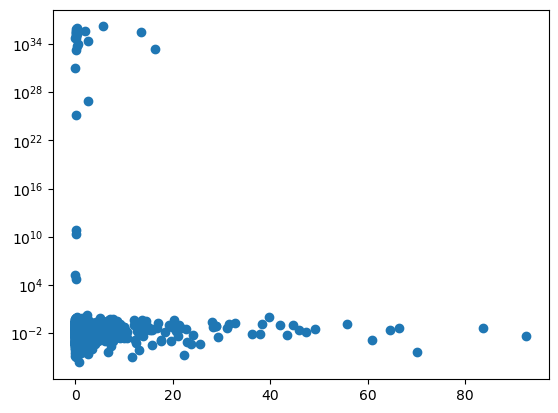

In [1234]:
plt.semilogy(mm.dissipation_potential.parameter[b].detach().square(), loss.amax(dim=1).detach(), 'o')

In [1217]:
mm.C[b][-1,-10:]

tensor([[0.0006],
        [0.0006],
        [0.0006],
        [0.0006],
        [0.0006],
        [0.0006],
        [0.0006],
        [0.0006],
        [0.0006],
        [0.0006]])

In [1210]:
q = mm.Q[b][-1].clone().detach().numpy()
p = mm.B[b][-1]/mm.C[b][-1].clone().detach().numpy()


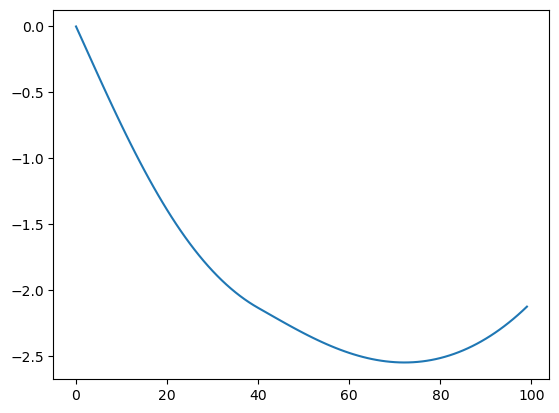

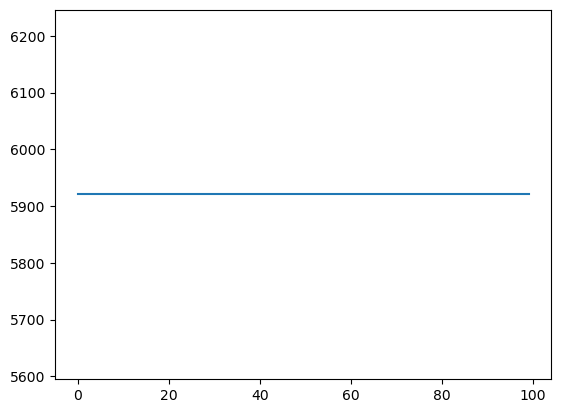

In [1213]:
plt.plot(q)
plt.show()
plt.plot(p)

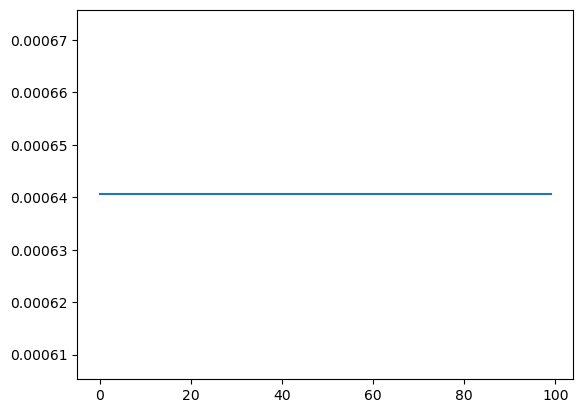

In [1183]:
plt.plot(mm.C[b][-1].detach())
# plt.plot(loss[b][-2].detach())
# plt.plot(loss[b][-3].detach())


In [999]:
xi[b][-15].detach()

tensor([[0.0000],
        [0.0001],
        [0.0002],
        [0.0002],
        [0.0002],
        [0.0003],
        [0.0003],
        [0.0004],
        [0.0004],
        [0.0005],
        [0.0005],
        [0.0006],
        [0.0006],
        [0.0007],
        [0.0008],
        [0.0008],
        [0.0009],
        [0.0009],
        [0.0010],
        [0.0010],
        [0.0011],
        [0.0011],
        [0.0012],
        [0.0012],
        [0.0013],
        [0.0013],
        [0.0014],
        [0.0014],
        [0.0015],
        [0.0015],
        [0.0016],
        [0.0016],
        [0.0017],
        [0.0018],
        [0.0018],
        [0.0019],
        [0.0019],
        [0.0020],
        [0.0020],
        [0.0021],
        [0.0021],
        [0.0022],
        [0.0022],
        [0.0023],
        [0.0023],
        [0.0024],
        [0.0024],
        [0.0025],
        [0.0025],
        [0.0026],
        [0.0026],
        [0.0027],
        [0.0027],
        [0.0028],
        [0.0028],
        [0

In [974]:
j = 16
b[j:-j].mean()

tensor(-4.0029e-06)

(array([977.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-2.94926792e-01,  1.58760779e+35,  3.17521558e+35,  4.76282357e+35,
         6.35043116e+35,  7.93803915e+35,  9.52564714e+35,  1.11132551e+36,
         1.27008623e+36,  1.42884711e+36,  1.58760783e+36]),
 <BarContainer object of 10 artists>)

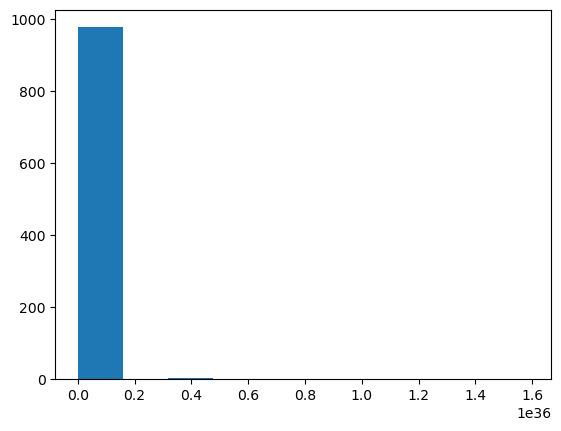

In [958]:
plt.hist(b[20:])

In [933]:
mm.xi_dot[667,73]

tensor([-0.0473], grad_fn=<SelectBackward0>)

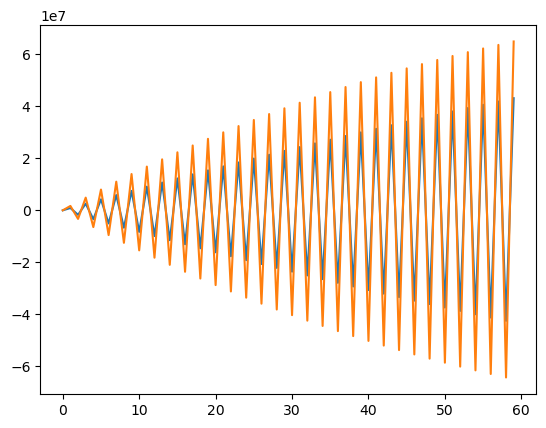

In [935]:
plt.plot(loss[667,:60].detach())
plt.plot(loss[224,:60].detach())

In [888]:
loss.mean()

tensor(-inf, grad_fn=<MeanBackward0>)

In [881]:
# mm.Q.isnan().sum(), mm.B.isnan().sum(), mm.C.isnan().sum(), mm.lam.isnan().sum()
mm.Q.isinf().sum(), mm.B.isinf().sum(), mm.C.isinf().sum(), mm.lam.isinf().sum()

(tensor(0), tensor(0), tensor(0), tensor(0))

In [875]:
mm.lam[:,1]

tensor([[-1.3475e-02],
        [ 1.2151e-02],
        [-8.5432e-03],
        [ 9.7766e-03],
        [-4.5668e-03],
        [-1.8354e-02],
        [-2.1107e-03],
        [ 1.0039e-01],
        [ 2.9019e-03],
        [-6.8165e-03],
        [ 4.2564e-03],
        [ 1.1506e-01],
        [-6.3402e-03],
        [ 3.0242e-03],
        [-1.5911e-01],
        [-1.0883e-01],
        [-2.2325e-02],
        [ 2.8475e-02],
        [ 5.7447e-03],
        [ 1.4705e-04],
        [-2.6542e-01],
        [-1.4348e-02],
        [-2.5857e-02],
        [-1.5723e-02],
        [-1.1104e-01],
        [ 2.3940e-02],
        [ 5.1690e-02],
        [-3.1587e-03],
        [ 7.3230e-03],
        [-1.9034e-03],
        [-9.4376e-02],
        [ 8.5355e-03],
        [ 4.5497e-02],
        [ 2.3636e-02],
        [-2.4583e-02],
        [-5.3416e-03],
        [ 1.8260e-01],
        [ 1.9556e-02],
        [ 7.8852e-02],
        [-1.4041e-03],
        [ 5.3052e-02],
        [-1.2936e-02],
        [-3.2237e-02],
        [ 7

In [858]:
mm.C.isnan().sum(), mm.lam.isnan().sum(), mm.Q.isnan().sum(), mm.B.isnan().sum(), mm.C.isnan().sum()

(tensor(0), tensor(0), tensor(0), tensor(0), tensor(0))

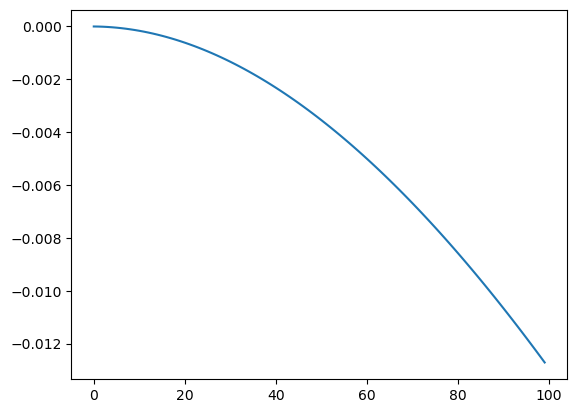

In [856]:
plt.plot(xi[5].detach().numpy(), label='xi')

In [766]:
a = torch.tensor([1e-19], requires_grad=True)
b = torch.abs(a)**1.6
grad = torch.autograd.grad(b, a, create_graph=True)[0]
double_grad = torch.autograd.grad(grad, a)[0]

tensor([1.], grad_fn=<MulBackward0>)

In [762]:
grad

tensor([12867729.])

In [749]:
a.grad

tensor([0.])

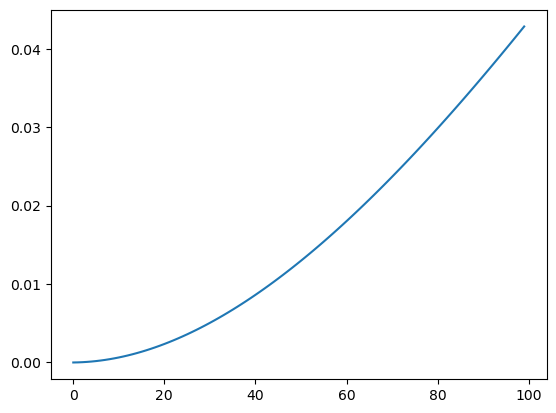

In [719]:
plt.plot(xi[-1].detach().numpy())

In [672]:
plt.plot(mm.D[0])

AttributeError: 'ViscoplasticMaterialModel' object has no attribute 'D'

In [646]:
1/torch.inf

0.0

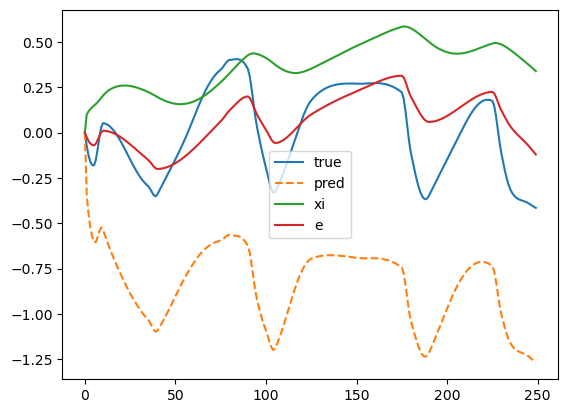

In [615]:
# plt.plot(xi[6].detach(), 'o')
i = 4
plt.plot(y[i].detach(), '-', label='true')
plt.plot(y_pred[i].detach(), '--', label='pred')
plt.plot(xi[i].detach(), '-', label='xi')
plt.plot(e[i].detach(), '-', label='e')
plt.legend()

In [622]:
mm.dissipation_potential.picnn1.picnn1.B.grad

tensor([[0.1030, 0.0025, 0.0425, 0.0426, 0.0269, 0.2934, 0.1405, 0.4164, 0.0645,
         0.0088]])

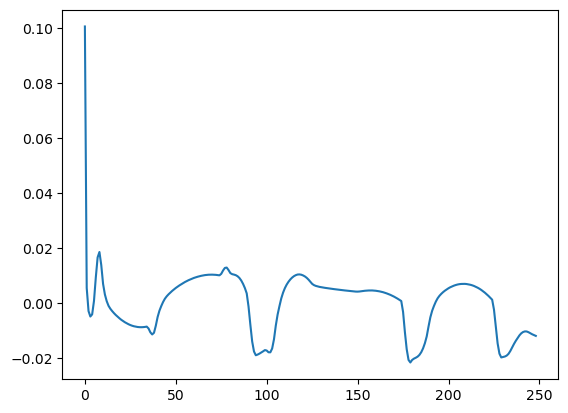

In [571]:
plt.plot(torch.diff(xi[i].detach(), dim=0))

In [590]:
mfeatures1 = mm.microstructure_encoder(E, Y, n, edot_0)[0]

In [591]:
stress = []
e.requires_grad_(True)
for i in range(250):
    e_ = e[:,i].clone()
    e.requires_grad_(True)
    stress.append(torch.autograd.grad(mm.energy_function(e_, xi[:,i], mfeatures1).sum(),e_)[0])
stress = torch.stack(stress, dim=1)

In [594]:
stress.shape

torch.Size([100, 250, 1])

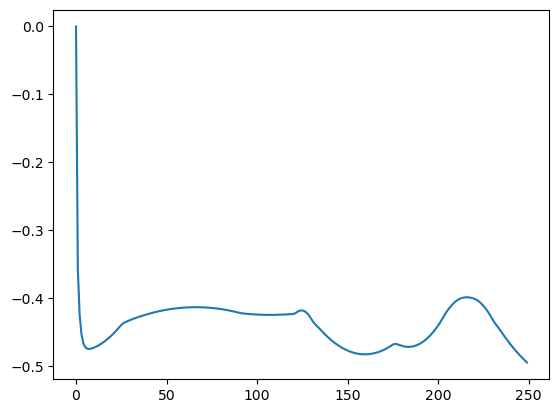

In [602]:
j = 15
plt.plot(stress[j].detach(), '-')

In [461]:
xi_dot = (
                torch.diff(xi, n=1, dim=1, prepend=torch.zeros_like(xi[:, [0]]))
                / mm.dt
            )

In [528]:
mm.dissipation_potential.picnn1.picnn2.fc3.fc4

AttributeError: 'Linear' object has no attribute 'fc4'

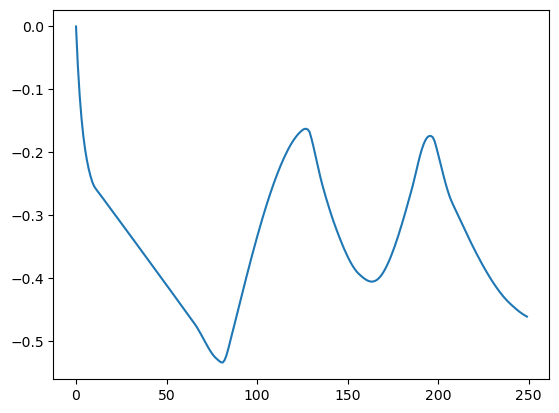

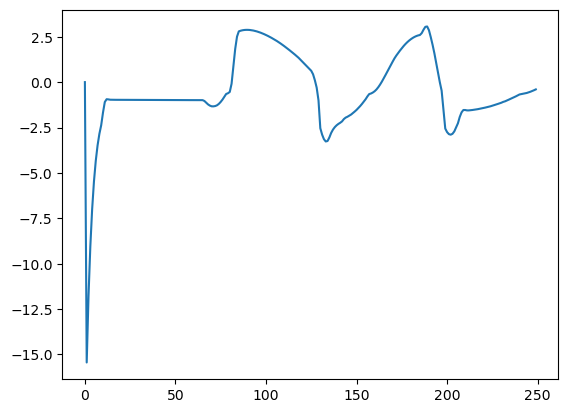

In [482]:
plt.plot(xi[0].detach())
plt.show()
plt.plot(xi_dot[0].detach())
plt.show()

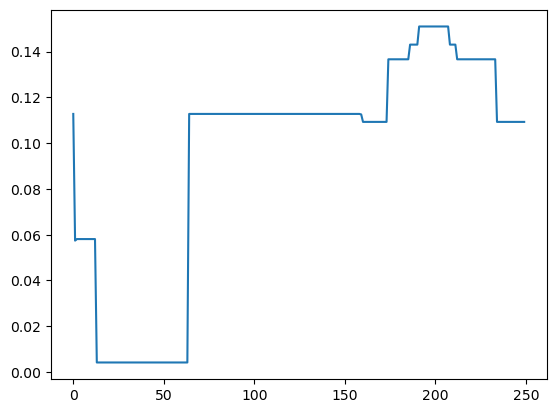

In [493]:
plt.plot(C[5])

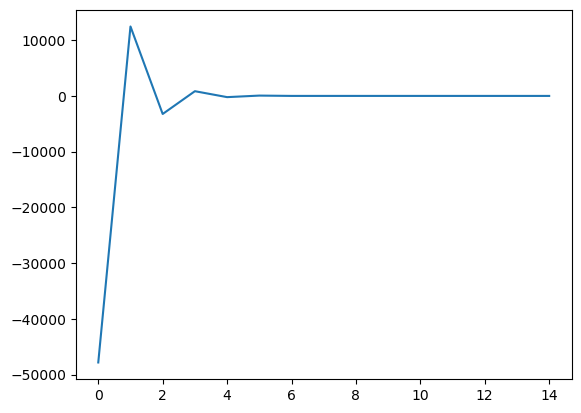

In [478]:
plt.plot(lam[0,235:])

In [467]:
xi_dot[:,2]

tensor([[-11.7809],
        [-10.7708],
        [-14.3840],
        [-10.0713],
        [-16.5304],
        [-12.7037],
        [-10.2911],
        [ -7.2355],
        [-11.4991],
        [-12.8899],
        [-14.0573],
        [ -7.7698],
        [-16.4113],
        [-11.8393],
        [-12.2119],
        [-12.4616],
        [-14.2521],
        [ -8.7726],
        [-10.1695],
        [-14.0342],
        [-12.6479],
        [-14.5820],
        [-15.6196],
        [-13.4234],
        [-11.8248],
        [-12.3401],
        [-12.2501],
        [-13.3444],
        [-13.8898],
        [-11.2789],
        [ -9.8567],
        [ -7.7181],
        [-10.5534],
        [-12.5355],
        [-15.9561],
        [-15.2842],
        [ -9.7780],
        [-13.5209],
        [ -7.5085],
        [-14.0151],
        [-10.0531],
        [-11.8350],
        [-14.8525],
        [-14.6739],
        [-12.8993],
        [-12.5703],
        [-11.0420],
        [ -9.8830],
        [-11.4463],
        [-11.0184],


In [460]:
lam[:,0]

tensor([[       -inf],
        [        inf],
        [-1.3105e+20],
        [-1.7941e-01],
        [ 1.8339e+03],
        [-1.1648e+27],
        [-7.9823e+08],
        [ 5.4631e-01],
        [-2.7836e-01],
        [ 1.0866e+05],
        [ 5.6295e-01],
        [ 6.4369e+13],
        [ 6.1575e-01],
        [-3.7177e-02],
        [       -inf],
        [-3.9169e+06],
        [-1.4980e+07],
        [-1.0738e+19],
        [-1.8569e+23],
        [-7.5567e+13],
        [-2.4040e+10],
        [-2.0032e+07],
        [ 3.8740e-01],
        [       -inf],
        [       -inf],
        [        inf],
        [        inf],
        [-7.6380e+11],
        [ 1.3984e-01],
        [-2.6633e+12],
        [        inf],
        [       -inf],
        [-1.9098e+00],
        [-5.9784e-01],
        [        inf],
        [ 1.0163e+01],
        [-4.6523e-01],
        [-7.5643e+00],
        [        inf],
        [ 1.4187e-01],
        [ 2.0958e+08],
        [        inf],
        [ 6.0661e-01],
        [ 8

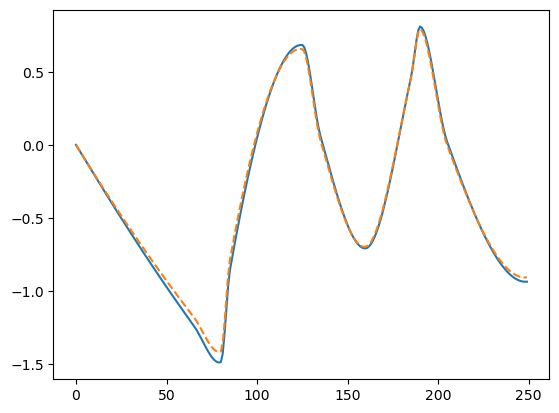

In [362]:
plt.plot(y_pred.detach().numpy()[0], label='pred')
plt.plot(y.detach().numpy()[0], '--', label='true')

In [291]:
c = torch.tensor([1, 2, 3])
c[c > 1]

tensor([2, 3])

In [234]:
torch.square(mm.micarostructure_encoder(E, Y, n, edot_0)[1]).min()

AttributeError: 'ViscoplasticMaterialModel' object has no attribute 'micarostructure_encoder'

In [107]:
a = torch.tensor([0.0], requires_grad=True)
b = torch.pow(torch.abs(a), 3)
grad = torch.autograd.grad(b, a, create_graph=True)[0]
grad2 = torch.autograd.grad(grad, a, create_graph=True)[0]
print(grad2)

tensor([0.], grad_fn=<AddBackward0>)


In [149]:
mm.fnm2.fc0.weight.grad.std(), mm.fnm2.fc0.weight.std()

(tensor(8.4093e-05), tensor(0.2932, grad_fn=<StdBackward0>))

In [39]:
mm.microstructure_encoder(E, Y, n, edot_0)[1][0]

tensor([nan, nan], grad_fn=<SelectBackward0>)

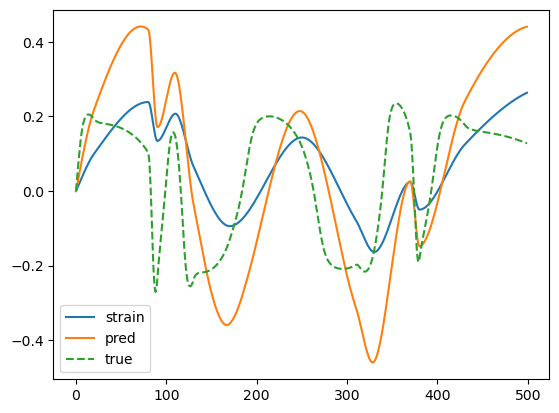

In [19]:
i = 19
plt.plot(e[i].detach().numpy(), label='strain')
plt.plot(y_pred.detach().numpy()[i], label='pred')
plt.plot(y.detach().numpy()[i], '--', label='true')
plt.legend()

In [20]:
a = torch.randn(10, requires_grad=True)
a
a[-1]

tensor(-0.0275, grad_fn=<SelectBackward0>)

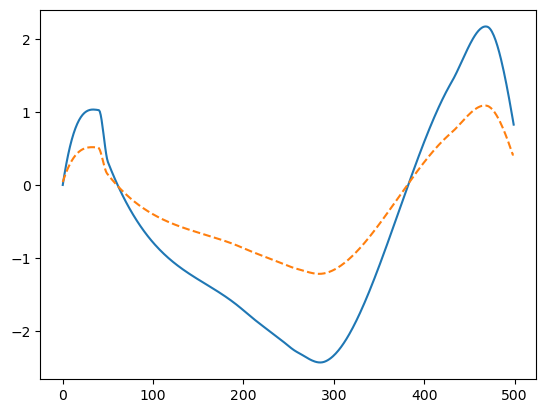

In [9]:
plt.plot(y_pred[0].detach().numpy(), label='pred')
plt.plot(y[0].detach().numpy(), '--', label='true')

In [ ]:
# !python evp_main.py --run_id $1 --mode offline --device cuda --data_path evp_data.txt --material_model m_evp_adjoint --hidden_dim 150 --epochs 2000 --lr 0.001 --batch_size 20a0 --niv 1 --step 10 --final_step 5000 --modes 4 --out_dim 1 --u_dim 10 --z_dim 10 --loss_type adjoint

In [51]:
file = "data/2026-02-08_Voronoi2D_process9_data.pkl"

In [52]:
with open(file, 'rb') as f:
    data = pickle.load(f)

In [53]:
data.keys()

dict_keys(['process_id', 'seed', 'n_samples', 'n_voronoi_max', 'n_voronoi_min', 'E_modulus_max', 'E_modulus_min', 'nu_modulus_max', 'nu_modulus_min', 'pr_max', 'pr_min', 'plane_strain', 'output_path', 'file_name', 'verbose', 'nt', 'T', 'maximum_iterations', 'relative_tolerance', 'n_cells', 'dim', 'FE_order', 'direct_solver', 'nu_prime', 'E_prime', 'kernel', 'time', 'voronoi_points', 'E_modulus_values', 'E_pr_values', 'nu_modulus_values', 'nu_pr_values'])

In [36]:
def s(a, b):
    print(a, b)
    return a + b

mul = lambda a, b: a * b + s(1, 1)

In [38]:
mul(2, 4)

1 1


10

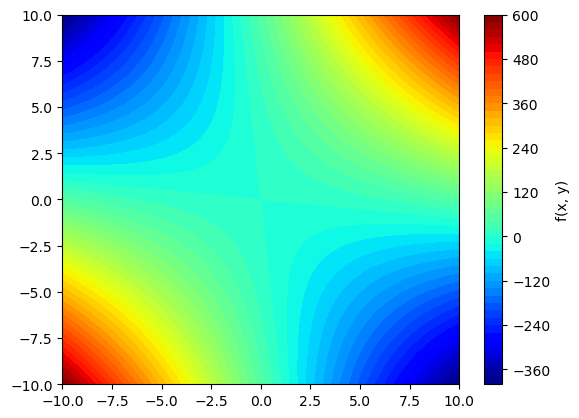

In [415]:
def f(x, y):
    return x**2/2 + y**2/2 + 5*x*y

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
plt.contourf(X, Y, Z, levels=50, cmap='jet')
plt.colorbar(label='f(x, y)')

In [12]:
!python evp_main.py --run_id debug --mode offline  --device cuda  --data_path evp_data1.txt --material_model m_evp_adjoint  --hidden_dim 150 --epochs 2000 --lr 0.0001  --batch_size 400  --niv 1 --step 20 --final_step 5000 --modes 3 --out_dim 1 --u_dim 10 --z_dim 10 --loss_type adjoint --tol 1e-4 --solver_lr 0.0005 --iter_limit 100 --num_workers 0

['data/2026-02-17_ElastoViscoplastic_PC1D_process0_data.pkl']
1 Number of internal variables in the viscoplastic material model.
wandb: WARNING The anonymous setting has no effect and will be removed in a future version.
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id k91w2pmn.
wandb: Tracking run with wandb version 0.25.0
wandb: W&B syncing is set to `offline` in this directory. Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
wandb: Run data is saved locally in wandb/offline-run-20260219_141011-k91w2pmn
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pyt